In [87]:
L = 6;

In [88]:
using PyCall
using Random
using LinearAlgebra
using SparseArrays
using DelimitedFiles
file = raw"gates_list_6.txt" # Change for every L.
M = readdlm(file)
# Name.
Gates_data_1 = M[:,1];
# Angle.
Gates_data_2 = M[:,2];
# Qubit.
Gates_data_3 = M[:,3];

In [89]:
Number_of_Gates = length(Gates_data_1)

416

In [90]:
Gates_data_2;

In [91]:
SEED = 32000
Random.seed!(SEED)
NOISE = 2*rand(Float64,Number_of_Gates).-1;

I2 = [1 0; 0 1];
Pauli_Z  = [1 0;0 -1];
Pauli_X  = [0 1;1 0]
H  = (1/sqrt(2))*[1 1;1 -1]
U1(theta) = [1 0; 0 exp(1im*theta)];
Rx(theta)       = sparse(exp(-1im*(theta/2)*collect(Pauli_X)));
Hadamard(noise) = sparse(exp(-1im*(pi/2+noise)*collect(I2-H))) #Ry(pi/2+noise)*Pauli_Z;
CX(noise)       = sparse(exp(-1im*((pi/2+noise))*collect(I2-Pauli_X))); # This is X gate.
Z_gate(noise)   = sparse(exp(-1im*(pi/2+noise)*collect(I2-Pauli_Z))) #Hadamard(noise)*CX(noise)*Hadamard(noise); # noise
Identity(dimension) = spdiagm(0 => ones(dimension));
int(x) = floor(Int,x);

# Single qubit gate

In [93]:
function single_qubit_gate_matrix(single_qubit_gate, qubit)
    
    ## The case Qubit=1 is treated differently because we need to
    # initialize the matrix as U before starting the kronecker product.
    
    if qubit == 1
        
        gate_matrix = sparse(single_qubit_gate)
        for i=2:L
            gate_matrix = kron(gate_matrix, I2)
        end
        
    #=
        Single qubit gates acting on qubits othe than the first.
        =#
    else
        
        gate_matrix = I2
        for i=2:L
            if i == qubit
                gate_matrix = kron(gate_matrix, single_qubit_gate)
            else
                gate_matrix = kron(gate_matrix, I2)
            end
        end
    end
    
    return gate_matrix
end;

# Single qubit controlled gate

In [94]:
function single_qubit_controlled_gate_matrix(single_qubit_gate,c,t)

    Z = [1 0;0 -1]
    # |0><0|.
    PI_0 = (I2+Z)/2
    # |1><1|.
    PI_1 = (I2-Z)/2
     
    Matrices = Dict("I" => I2,"PI_0" => PI_0,"U" => single_qubit_gate, "PI_1" => PI_1)
    
    p0 = fill("I", L)
    p1 = fill("I", L)
    
    p0[c] = "PI_0"
    p1[c] = "PI_1"
    p1[t] = "U"

    
    PI_0_matrix = Matrices[p0[1]]
    for i = 2:L
        PI_0_matrix = kron(PI_0_matrix,Matrices[p0[i]])
    end        
        
    PI_1_matrix = Matrices[p1[1]]   
    for i = 2:L
        PI_1_matrix = kron(PI_1_matrix,Matrices[p1[i]])        
    end
           
    return sparse(PI_0_matrix + PI_1_matrix)     
end;

# Entanglement entropy code

In [95]:
using PyCall
py"""
import numpy
import numpy.linalg
def adjoint(psi):
    return psi.conjugate().transpose()
def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())
def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))
def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))
def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns
def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol
def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol
def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)
    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))
    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger
"""

# Noiseless Grover operator

In [96]:
#=
U_0 = Identity(2^L)#[-1 0 0 0; 0 1 0 0; 0 0 1 0;0 0 0 1];
U_0[1,1] = -1
A = ones(2^L,2^L);
U_x = (2/2^L)*A-Identity(2^L); # 2\s><s|-I
G_exact = U_x*U_0
#V = py"eigu"(G_exact)[2];
=#

# Grover operator construction function code

In [97]:
function Grover_delta(DELTA)

    GROVER_DELTA = Identity(2^L)
    # U_x
    for i = 1:Number_of_Gates
        
        
        if Gates_data_1[i] == "x"
            
            
            epsilon = NOISE[i]
            GROVER_DELTA *= single_qubit_gate_matrix(CX(DELTA*epsilon), Gates_data_3[i]+1)        
        
        elseif Gates_data_1[i] == "h"
            
            
            epsilon = NOISE[i]
            GROVER_DELTA *= single_qubit_gate_matrix(Hadamard(DELTA*epsilon), Gates_data_3[i]+1)
            
            
        elseif Gates_data_1[i] == "z"
            
            
            epsilon = NOISE[i]
            GROVER_DELTA *= single_qubit_gate_matrix(Z_gate(DELTA*epsilon), Gates_data_3[i]+1)
                
        elseif Gates_data_1[i] == "rx"
        
            epsilon = NOISE[i]       
            GROVER_DELTA *= single_qubit_gate_matrix(Rx(Gates_data_2[i]+DELTA*epsilon),Gates_data_3[i]+1)   

            
        elseif Gates_data_1[i] == "u1"
        
            epsilon = NOISE[i]       
            GROVER_DELTA *= single_qubit_gate_matrix(U1(Gates_data_2[i]+DELTA*epsilon),Gates_data_3[i]+1)
                
        elseif Gates_data_1[i] == "cx"

            epsilon = NOISE[i]     
            GROVER_DELTA *= single_qubit_controlled_gate_matrix(CX(DELTA*epsilon), Gates_data_2[i]+1, Gates_data_3[i]+1)    
        else
            println("Kant")
        end
    end

    
    return -GROVER_DELTA'
end;

In [98]:
Gd = Grover_delta(0.0);

In [135]:
#=
The following function returns the matrix of rolling operator.
=#
function One_Roll_Operator(number_of_qubits::Int64)
    
    #= Function converts a binary number to a decimal number. =#
    Bin2Dec(BinaryNumber) = parse(Int, string(BinaryNumber); base=2);
    
    #= Function converts a decimal number to a binary number. =#
    function Dec2Bin(DecimalNumber::Int64) 
        
        init_binary = string(DecimalNumber, base = 2);
        
        #=
        While converting numbers from decimal to binary, for example, 1
        is mapped to 1, to make sure that every numbers have N qubits in them,
        the following loop adds leading zeros to make the length of the binary
        string equal to N. Now, 1 is mapped to 000.....1 (string of length N).
        =#
        
        while length(init_binary) < number_of_qubits
            init_binary = "0"*init_binary
        end
        return init_binary
    end
    
    #=
    The following function takes a binary string as input
    and rolls the qubits by one and returns the rolled binary string.
    =#
    Roll_String_Once(binary_string) = binary_string[end]*binary_string[1:end-1]
    
    #= Initializing the rolling operator. =#
    R = zeros(Float64,2^number_of_qubits,2^number_of_qubits);
    
    #= The numbers are started from 0 to 2^L-1 because for L qubits,
    binary representation goes from 0 to 2^L-1.=#
    
    for i = 0:2^number_of_qubits-1 
        
        #=
        Steps in the following loop.
        (1) The number is converted from decimal to binary.
        (2) The qubits are rolled once.
        (3) The rolled binary number is converted to decimal number.
        (4) The corresponding position in R is replaced by 1.
        =#
        
        #= The index in R will be shifted by 1 as Julia counts from 1. =#
        R[i+1,Bin2Dec(Roll_String_Once(Dec2Bin(i)))+1] = 1
    end
    
    return sparse(R)
end;
          
#=
The following function returns the von-Neumann entropy of a given
wavefunction. The sub-system size is L/2.
=#

function entanglement_entropy(Psi)
    
    sub_system_size = floor(Int,L/2)
    
    Psi = Psi/norm(Psi)
    
    function psi(s)
        return Psi[2^(sub_system_size)*s+1:2^(sub_system_size)*s+2^(sub_system_size)]
    end
    
    #= (s,s_p) element of the reduced density matrix is given by psi(s_p)^(\dagger)*psi(s). =#
    rhoA(s,s_p) = psi(s_p)' * psi(s)
        
    M = zeros(ComplexF64,2^sub_system_size,2^sub_system_size)
    
    #=
    Since the matrix is symmetric only terms above the diagonal will be calculated.
    =#
    for i = 0:2^sub_system_size-1
        for j = 0:2^sub_system_size-1
            if i <= j
                M[i+1,j+1] = rhoA(i,j)
            else
                M[i+1,j+1] = M[j+1,i+1]'
            end
        end
    end 
    
    #= Eigenvalues of M. The small quantity is added to avoid singularity in log.=#
    w = eigvals(M).+1.e-10
    
    return real(-sum([w[i]*log(w[i]) for i = 1:2^(sub_system_size)]))
end;          
    
              
function average_entanglement_entropy(initial_wavefunction)
    initial_wavefunction = initial_wavefunction/norm(initial_wavefunction)
    R = One_Roll_Operator(L)
    rolled_wavefunction = R * initial_wavefunction
    rolled_entropies = [entanglement_entropy(rolled_wavefunction)]
    for i = 2:L
        rolled_wavefunction = R * rolled_wavefunction
        push!(rolled_entropies,entanglement_entropy(rolled_wavefunction))
    end
    
    return sum(rolled_entropies)/L
end;

In [136]:
eigenvalue_file       = open("eigenvalues.txt", "w");
deltas = []
Ys = []
Entropies = []
              
Num = 100
for i=0:Num
    delta = 0.2*i/Num
    Op = collect(Grover_delta(delta))
    EIGU = py"eigu"(Op)
    X = string(delta)
    Y = real(1im*log.(EIGU[1]))
    V = EIGU[2]
    
    for j=1:2^L
        write(eigenvalue_file , string(delta))
        write(eigenvalue_file , "\t")  # Add a tab indentation between the columns
        write(eigenvalue_file , string(real(Y[j])))
        write(eigenvalue_file , "\t")
        write(eigenvalue_file , string(average_entanglement_entropy(V[1:2^L,j:j])))
        write(eigenvalue_file , "\n")  # Add a newline character to start a new line
    #end
        #py"Write_file"(delta, real(Y[j]), average_entanglement_entropy(V[1:2^L,j:j]))
    end
end
close(eigenvalue_file)

In [137]:
using Plots
using DelimitedFiles
using ColorSchemes
#using CSV
using LaTeXStrings
#using PyPlot

In [138]:
file = "eigenvalues.txt"
M = readdlm(file)
delta = M[:,1]; # eigenvalue index
quasienergy = M[:,2]; # level stat
entanglement = M[:,3]; # level stat std

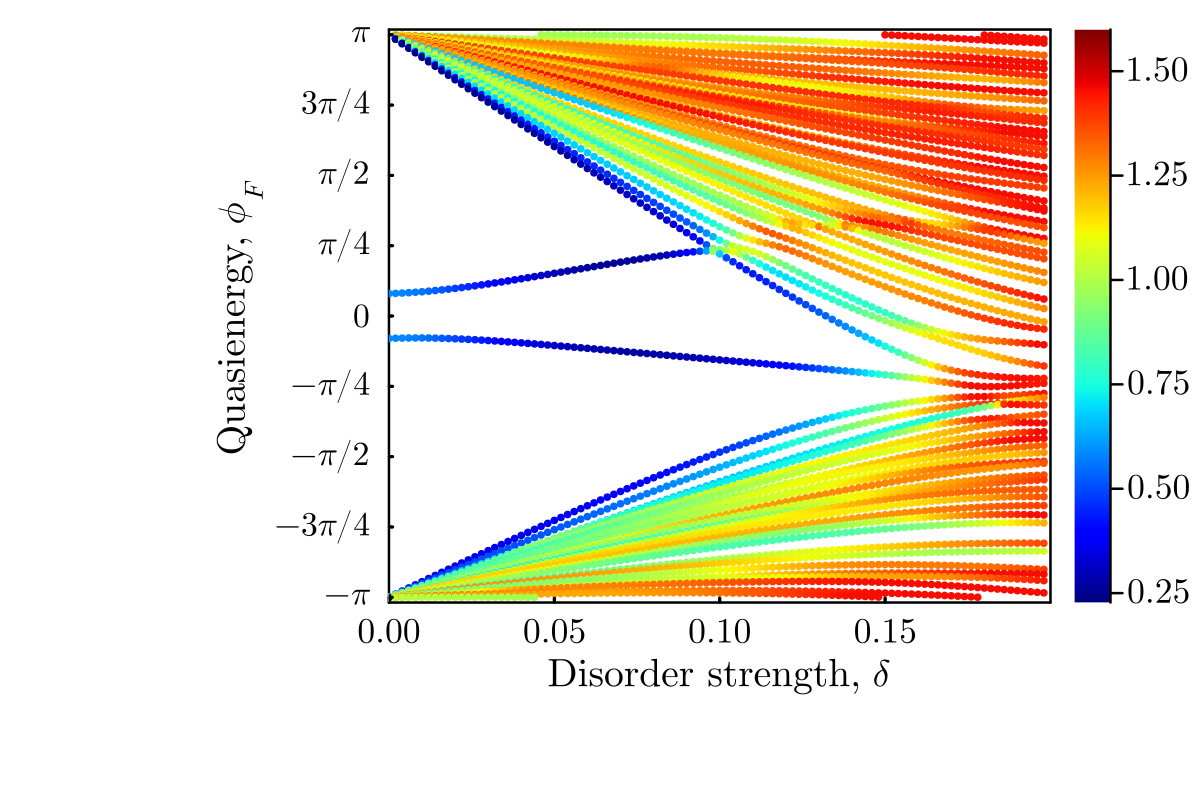

In [141]:
gr()
MSW = 0.4
Linewidth  = 0.6
Markersize = 1.7
MarkerStrokeWidth = 0.0;

plot_font = "Computer Modern"
default(fontfamily=plot_font)



MyTitle = "L = "*string(L)*", Page Value = "*string(round(0.5*L*log(2)-0.5;digits = 2))*" ";
p = plot(delta,quasienergy ,
    seriestype = :scatter,
    markerstrokecolor = "grey30",
    markerstrokewidth=MarkerStrokeWidth,
    markersize=Markersize,
    thickness_scaling = 2.5,
    xlims=(0,0.2), 
    ylims=(-3.2,3.2),
    title = "",
    label = "",
    #legend = :bottomleft,
    dpi=300,
    zcolor = entanglement,
    grid = false,
    #colorbar_title = "Average entanglement entropy",
    right_margin = Plots.mm,
    font="CMU Serif",
    color = :jet1,
    #:linear_bmy_10_95_c78_n256,#:diverging_rainbow_bgymr_45_85_c67_n256,#:linear_bmy_10_95_c78_n256,#:rainbow1,
    #right_margin = 2Plots.mm,
    left_margin = Plots.mm,
    titlefontsize=10,
    guidefontsize=10,
    tickfontsize=9,
    legendfontsize=8,
    framestyle = :box
    )

yticks!([-pi,-3*pi/4,-pi/2,-pi/4,0,pi/4,pi/2,3*pi/4,pi], [L"-\pi",L"-3\pi/4",L"-\pi/2",L"-\pi/4",L"0",L"\pi/4",L"\pi/2",L"3\pi/4",L"\pi"])

function ticks_length!(;tl=0.01)
    p = Plots.current()
    xticks, yticks = Plots.xticks(p)[1][1], Plots.yticks(p)[1][1]
    xl, yl = Plots.xlims(p), Plots.ylims(p)
    x1, y1 = zero(yticks) .+ xl[1], zero(xticks) .+ yl[1]
    sz = p.attr[:size]
    r = sz[1]/sz[2]
    dx, dy = tl*(xl[2] - xl[1]), tl*r*(yl[2] - yl[1])
    plot!([xticks xticks]', [y1 y1 .+ dy]', c=:black, labels=false,linewidth = 1.3)
    plot!([x1 x1 .+ dx]', [yticks yticks]', c=:black, labels=false,linewidth = 1.3, xlims=xl, ylims=yl)
    return Plots.current()
end
ticks_length!(tl=0.005)
plot!(size=(1200,800))
#plot!(yticks = ([(-pi) : (-pi/2): (-pi/4): 0: (pi/4) : (pi/2) : pi;], ["-\\pi", "-\\pi/2", "-\\pi/4","0","\\pi/4","\\pi/2","\\pi"]))
#hline!([[-quasienergy]],lc=:deeppink1,linestyle= :dashdotdot,legend=false)
#hline!([ [0]],lc=:deeppink1,linestyle= :dashdotdot,legend=false)
#hline!([ [quasienergy]],lc=:deeppink1,linestyle= :dashdotdot,legend=false)
xlabel!("Disorder strength, \$\\delta\$")
ylabel!("Quasienergy, \$\\phi_{F}\$")
plot!(background_color=:white)
#savefig("6_32000_plot_data_0.0_0.4.png")

In [140]:
round(0.5*L*log(2)-0.5;digits = 2)

1.58